In [1]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

In [2]:
import itertools

import numpy as np

import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

# Load Dataset

<div dir="rtl">
مجموعه داده مورد مطالعه مربوط به اطلاعات ثبت شده از صوت افراد مختلف می باشد که به منظور تشخیص بیماری پارکینسون مورد استفاده قرار می گیرند. این مجموعه داده شامل ۱۸۸ بیمار پارکینسون (۱۰۷ مرد و ۸۱ زن) و ۶۴ فرد سالم (۲۳ مرد و ۴۱ زن) می باشد. آزمایش مد نظر به منظور جلوگیری از خطا برای هر فرد سه بار تکرار شده است. با توجه به کم بودن تعداد داده ها از تجمیع کردن آن ها خودداری می کنیم و هر داده را مستقل در نظر می گیریم. پس در نهایت مجموعه داده شامل ۷۵۶ تا داده با تعداد ابعاد ویژگی ۷۵۳ می باشد.
</div>

In [3]:
import pandas as pd

df = pd.read_csv('pd_speech_features.csv', index_col='id')

df = df.astype({'gender': 'int8', 'class': 'int8'})

display(df)
df.info()

,gender,PPE,DFA,RPDE,numPulses,numPeriodsPulses,meanPeriodPulses,stdDevPeriodPulses,locPctJitter,locAbsJitter,rapJitter,ppq5Jitter,ddpJitter,locShimmer,locDbShimmer,apq3Shimmer,apq5Shimmer,apq11Shimmer,ddaShimmer,meanAutoCorrHarmonicity,meanNoiseToHarmHarmonicity,meanHarmToNoiseHarmonicity,minIntensity,maxIntensity,meanIntensity,f1,f2,f3,f4,b1,b2,b3,b4,GQ_prc5_95,GQ_std_cycle_open,GQ_std_cycle_closed,GNE_mean,GNE_std,GNE_SNR_TKEO,GNE_SNR_SEO,...,tqwt_skewnessValue_dec_34,tqwt_skewnessValue_dec_35,tqwt_skewnessValue_dec_36,tqwt_kurtosisValue_dec_1,tqwt_kurtosisValue_dec_2,tqwt_kurtosisValue_dec_3,tqwt_kurtosisValue_dec_4,tqwt_kurtosisValue_dec_5,tqwt_kurtosisValue_dec_6,tqwt_kurtosisValue_dec_7,tqwt_kurtosisValue_dec_8,tqwt_kurtosisValue_dec_9,tqwt_kurtosisValue_dec_10,tqwt_kurtosisValue_dec_11,tqwt_kurtosisValue_dec_12,tqwt_kurtosisValue_dec_13,tqwt_kurtosisValue_dec_14,tqwt_kurtosisValue_dec_15,tqwt_kurtosisValue_dec_16,tqwt_kurtosisValue_dec_17,tqwt_kurtosisValue_dec_18,tqwt_kurtosisValue_dec_19,tqwt_kurtosisValue_dec_20,tqwt_kurtosisValue_dec_21,tqwt_kurtosisValue_dec_22,tqwt_kurtosisValue_dec_23,tqwt_kurtosisValue_dec_24,tqwt_kurtosisValue_dec_25,tqwt_kurtosisValue_dec_26,tqwt_kurtosisValue_dec_27,tqwt_kurtosisValue_dec_28,tqwt_kurtosisValue_dec_29,tqwt_kurtosisValue_dec_30,tqwt_kurtosisValue_dec_31,tqwt_kurtosisValue_dec_32,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,0.85247,0.71826,0.57227,240,239,0.008064,0.000087,0.00218,0.000018,0.00067,0.00129,0.00200,0.05883,0.517,0.03011,0.03496,0.04828,0.09034,0.970805,0.036223,18.995,69.997496,76.088046,72.465512,539.342735,1031.849040,2447.162183,3655.054806,101.092218,83.147440,255.214830,396.643631,0.77778,11.7245,2.8277,1.17300,0.265120,0.083127,1200445.612,...,0.071728,0.010352,-2.730300,66.5007,36.9934,26.3508,51.9577,21.5451,8.2488,8.0024,6.9635,6.9189,5.0622,4.6068,7.7218,2.7224,2.4171,2.9383,4.2077,3.1541,2.8531,2.7496,2.1550,2.9457,2.1993,1.9830,1.8314,2.0062,1.6058,1.5466,1.5620,2.6445,3.8686,4.2105,5.1221,4.4625,2.6202,3.0004,18.9405,1
0,1,0.76686,0.69481,0.53966,234,233,0.008258,0.000073,0.00195,0.000016,0.00052,0.00112,0.00157,0.05516,0.502,0.02320,0.03675,0.06195,0.06961,0.984322,0.017974,21.497,67.415903,73.046374,71.528945,564.363614,1016.367294,2383.565201,3498.681572,58.465428,86.487292,248.357127,218.229722,0.81250,13.8284,2.8908,1.02210,0.220040,0.127410,1298455.445,...,0.729330,0.780410,5.229400,8643.9860,3962.0554,2976.2411,4329.0607,4005.1329,1127.6762,116.5331,20.2332,13.6395,12.5514,13.6965,60.8974,6.2958,3.0323,3.4039,4.3794,2.4329,2.0585,2.1839,2.2061,3.0999,1.9824,1.6227,1.5783,2.0470,1.5772,1.5530,1.5589,3.6107,23.5155,14.1962,11.0261,9.5082,6.5245,6.3431,45.1780,1
0,1,0.85083,0.67604,0.58982,232,231,0.008340,0.000060,0.00176,0.000015,0.00057,0.00111,0.00171,0.09902,0.897,0.05094,0.06497,0.07772,0.15282,0.974846,0.026313,17.651,62.661706,71.633549,68.086583,548.444604,1032.406341,2357.826954,3678.128717,160.387771,54.685168,151.694847,84.240339,0.81818,26.9273,2.6975,0.84951,0.157560,0.116890,1272869.841,...,0.269510,-0.005522,0.350540,29.2717,32.4971,38.9453,85.1480,62.5132,9.7308,6.8890,6.1357,5.4926,3.9078,4.0864,6.9828,3.4411,3.5173,3.7204,4.2212,3.4881,3.4851,3.3007,2.0427,3.1436,2.1203,1.6627,1.6731,3.2597,1.5921,1.5399,1.5643,2.3308,9.4959,10.7458,11.0177,4.8066,2.9199,3.1495,4.7666,1
1,0,0.41121,0.79672,0.59257,178,177,0.010858,0.000183,0.00419,0.000046,0.00149,0.00268,0.00446,0.05451,0.527,0.02395,0.02857,0.04462,0.07185,0.968343,0.042003,19.865,76.306989,81.000749,79.190593,819.529588,1201.813897,3154.035654,4122.163933,238.667052,191.984916,573.752909,526.147599,0.98548,139.5744,1.6961,0.83405,0.172950,0.147370,1932289.206,...,0.366920,-0.492650,0.191640,591.0116,65.3827,53.9852,45.4458,34.6650,88.3259,46.6869,23.2911,19.2022,42.3957,100.3649,7.1967,6.3892,6.5496,6.0264,4.7656,4.8909,4.25

<class 'pandas.core.frame.DataFrame'>
Int64Index: 756 entries, 0 to 251
Columns: 754 entries, gender to class
dtypes: float64(749), int64(3), int8(2)
memory usage: 4.3 MB


# Normalize Data

<div dir="rtl">
با توجه به اینکه ابعاد مختلف بردار ویژگی در بازه های مختلفی دارند و بیشتر طبقه بند ها مد نظر برای این مسئله مبتنی بر فاصله هستند باید داده ها را normalize کنیم. برای این کار از روش MinMaxScaler استفاده می کنیم که تمام ابعاد بردار ویژگی را به بازه ی 0-1 منتقل می کند
</div>

In [4]:
from sklearn.preprocessing import MinMaxScaler

X_all = df.iloc[:, :-1].to_numpy()
y_all = df.iloc[:, -1].to_numpy()

# scale data
t = MinMaxScaler()
t.fit(X_all)
X_all = t.transform(X_all)

<div dir="rtl">
به منظور مقایسه مدل های مختلف مجموعه داده هایی که در اختیار داریم را به دو قسمت training و validation تقسیم می کنیم. از داده های مجموعه ی training برای آموزش مدل و تنظیم hyperparameters استفاده می کنیم و از مجموعه validation برای مقایسه عملکرد مدل های مختلف کمک می گیریم. عملیات تقسیم را به این صورت انجام میدهیم که ۲۰ درصد از کل داده ها را بعنوان مجموعه validation در نظر می گیریم و بقیه داده ها را بعنوان مجموعه training.
<br />
training: ۶۰۴ × ۷۵۳
<br />
validation: ۱۵۲ × ۷۵۳
</div>

In [5]:
from sklearn.model_selection import train_test_split

X, X_val, y, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=85)

X.shape, X_val.shape

((604, 753), (152, 753))

# Resampling Data

<div dir="rtl">
با توجه به نامتعادل بودن تعداد داده های دو کلاس Parkinson Disease و Health Control به منظور افزایش کیفیت طبقه بند عملیات oversampling را برای کلاس Health Control که تعداد کمتری دارد انجام می دهیم. پس از انجام oversampling تعداد داده های دو کلاس با هم برابر می شوند.
</div>

<br />

<div dir="rtl">
دقت شود که عملیات oversampling تنها به روی داده های training انجام می شود و مجموعه validation بدون تغییر باقی می ماند. یا توجه به نامتعادل بودن تعداد داده های دو کلاس PD و HC در مجموعه validation علاوه بر معیار accuracy از معیار f1 score و confusion matrix نیز استفاده می کنیم
</div>

In [6]:
from imblearn.over_sampling import RandomOverSampler

# over-sampling
ros = RandomOverSampler(random_state=85)
X, y = ros.fit_resample(X, y)

X[y==0].shape, X[y==1].shape

((450, 753), (450, 753))

<div dir="rtl">
از آنجا که این فایل مربوط به گزارش نهایی می باشد از آوردن تمامی حالت های خواسته شده برای پروژه نهایی خودداری شده است و فقط حالت های مناسب ذکر شده است.

<br />
برای مشاهده پیاده سازی و بررسی تمامی حالت ها به فایل ML Final Project.ipynb مراجعه شود
</div>

# Classification without Dimensionality Reduction

## Generative

### Parzen

<div dir="rtl">
در این قسمت با استفاده از روش تخمین ناپارامتری Parzen Window اقدام به ساختن یک طبقه بند Bayes Optimal Classifier می کنیم. با توجه به اینکه تعداد داده ها دو کلاس PD و HC در مجموعه training برابر می باشد احتمال پیشین مربوط به دو کلاس را برابر در نظر می گیریم.
<br />
برای ساخت طبقه بند تخمین Parzen را با پنجره ی gaussian در نظر می گیریم و برای بدست آوردن bandwidth بهینه از روش k-fold (k=4) بعنوان cross validation استفاده می کنیم.
</div>

In [7]:
import numpy as np

from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

bws = np.linspace(0.1, 1, 10)
accs = []
f1s = []
for bw in bws:
  kf = KFold(n_splits=4, shuffle=True, random_state=85)

  accs_cv = []
  f1s_cv = []
  for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    kde0 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(X_train[y_train==0])
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(X_train[y_train==1])

    prob0 = kde0.score_samples(X_test)
    prob1 = kde1.score_samples(X_test)
    y_pred = (prob1 >= prob0).astype('int8')
    accs_cv.append(accuracy_score(y_test, y_pred))
    f1s_cv.append(f1_score(y_test, y_pred))

  accs.append(accs_cv)
  f1s.append(f1s_cv)

<div dir="rtl">
با توجه به اینکه تعداد داده های دو کلاس متعادل هستند تنها از معیار accuracy برای انتخاب مقدار بهینه bandwidth استفاده می کنیم. همانطور که در شکل زیر مشاهده می شود مقدار بهینه bandwidth برابر 0.4 می باشد. (این مقدار بیشترین accuracy را بدون توجه به پراکندگی دارد) 
</div>

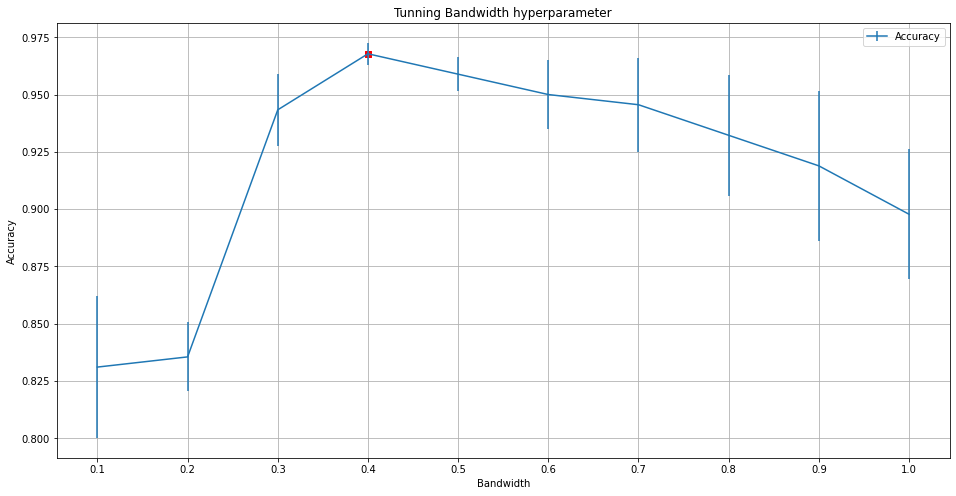

In [8]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('Tunning Bandwidth hyperparameter')
plt.xlabel('Bandwidth')
plt.ylabel('Accuracy')
plt.errorbar(bws, np.mean(accs, axis=1), np.std(accs, axis=1), label='Accuracy')
plt.xticks(bws)
plt.grid()

criterion_acc = np.mean(accs, axis=1)
idx_opt = np.argmax(criterion_acc)
bw_optimal = bws[idx_opt]

plt.scatter(bw_optimal, np.mean(accs, axis=1)[idx_opt], color='red', marker='s')

plt.legend()
plt.show()

<div dir="rtl">
حال با استفاده از bandwidth بهینه اقدام به ساخت طبقه بند با تمام داده های آموزشی و ارزیابی آن با مجموعه validation می کنیم
</div>

In [9]:
from sklearn.neighbors import KernelDensity

kde0 = KernelDensity(kernel='gaussian', bandwidth=bw_optimal).fit(X[y==0])
kde1 = KernelDensity(kernel='gaussian', bandwidth=bw_optimal).fit(X[y==1])

prob0 = kde0.score_samples(X_val)
prob1 = kde1.score_samples(X_val)

y_pred = (prob1 >= prob0).astype('int8')

              precision    recall  f1-score   support

          HC     0.8919    0.8684    0.8800        38
          PD     0.9565    0.9649    0.9607       114

    accuracy                         0.9408       152
   macro avg     0.9242    0.9167    0.9203       152
weighted avg     0.9404    0.9408    0.9405       152



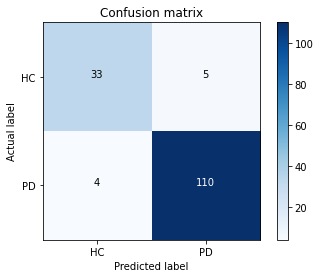

In [10]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

parzen_report = classification_report(y_val, y_pred, target_names=['HC', 'PD'],
                                      digits=4, output_dict=True)
print(classification_report(y_val, y_pred, target_names=['HC', 'PD'], digits=4))

cm = confusion_matrix(y_val, y_pred)  
plot_confusion_matrix(cm, ['HC', 'PD'])

## Discriminative

### SVM

<div dir="rtl">
در این قسمت اقدام به ساخت طبقه بند SVM با kernel نمایی می کنیم. برای بدست آوردن مقدار بهینه برای degree از روش k-fold(k=4) بعنوان cross validation استفاده می کنیم.
</div>

In [11]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC

degress = range(1, 15)
accs = []
f1s = []
for d in degress:
  svm = SVC(kernel='poly', degree=d)
  cv = KFold(n_splits=4, shuffle=True, random_state=85)
  cv_results = cross_validate(svm, X, y, cv=cv, scoring=('accuracy', 'f1'))

  accs.append(cv_results['test_accuracy'])
  f1s.append(cv_results['test_f1'])

<div dir="rtl">
با توجه به اینکه تعداد داده های دو کلاس متعادل هستند تنها از معیار accuracy برای انتخاب مقدار بهینه degree استفاده می کنیم. همانطور که در شکل زیر مشاهده می شود مقدار بهینه degree برابر 14 می باشد. (این مقدار بیشترین accuracy را بدون توجه به پراکندگی دارد) 
</div>

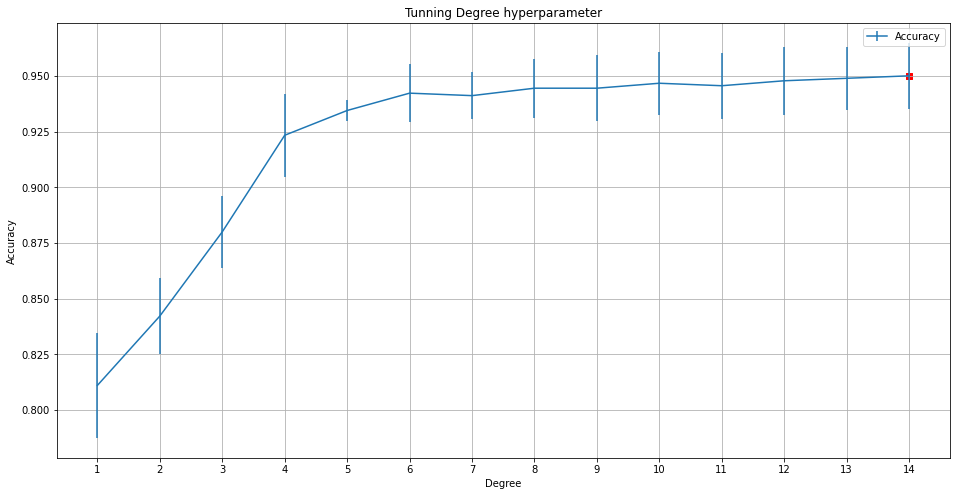

In [12]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('Tunning Degree hyperparameter')
plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.errorbar(degress, np.mean(accs, axis=1), np.std(accs, axis=1), label='Accuracy')
plt.xticks(degress)
plt.grid()

criterion_acc = np.mean(accs, axis=1)
idx_opt = np.argmax(criterion_acc)
degree_optimal = degress[idx_opt]

plt.scatter(degree_optimal, np.mean(accs, axis=1)[idx_opt], color='red', marker='s')

plt.legend()
plt.show()

<div dir="rtl">
حال با استفاده از degree بهینه اقدام به ساخت طبقه بند با تمام داده های آموزشی و ارزیابی آن با مجموعه validation می کنیم
</div>

In [13]:
from sklearn.svm import SVC

svm = SVC(kernel='poly', degree=degree_optimal)
svm.fit(X, y)

y_pred = svm.predict(X_val)

              precision    recall  f1-score   support

          HC     0.9355    0.7632    0.8406        38
          PD     0.9256    0.9825    0.9532       114

    accuracy                         0.9276       152
   macro avg     0.9306    0.8728    0.8969       152
weighted avg     0.9281    0.9276    0.9250       152



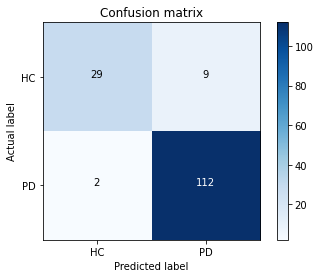

In [14]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

svm_report = classification_report(y_val, y_pred, target_names=['HC', 'PD'],
                                   digits=4, output_dict=True)
print(classification_report(y_val, y_pred, target_names=['HC', 'PD'], digits=4))

cm = confusion_matrix(y_val, y_pred)  
plot_confusion_matrix(cm, ['HC', 'PD'])

### KNN Classifier

<div dir="rtl">
در این قسمت اقدام به ساخت طبقه بند KNN می کنیم و برای بدست آوردن تعداد بهینه neighbor از روش k-fold(k=4) بعنوان cross validation استفاده می کنیم
</div>

In [15]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

neighbors = range(1, 10)
accs = []
f1s = []
for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors=k)
  cv = KFold(n_splits=4, shuffle=True, random_state=85)
  cv_results = cross_validate(knn, X, y, cv=cv, scoring=('accuracy', 'f1'))

  accs.append(cv_results['test_accuracy'])
  f1s.append(cv_results['test_f1'])

<div dir="rtl">
با توجه به اینکه تعداد داده های دو کلاس متعادل هستند تنها از معیار accuracy برای انتخاب مقدار بهینه neighbor استفاده می کنیم. همانطور که در شکل زیر مشاهده می شود مقدار بهینه neighbor برابر 1 می باشد. (این مقدار بیشترین accuracy را بدون توجه به پراکندگی دارد) 
</div>

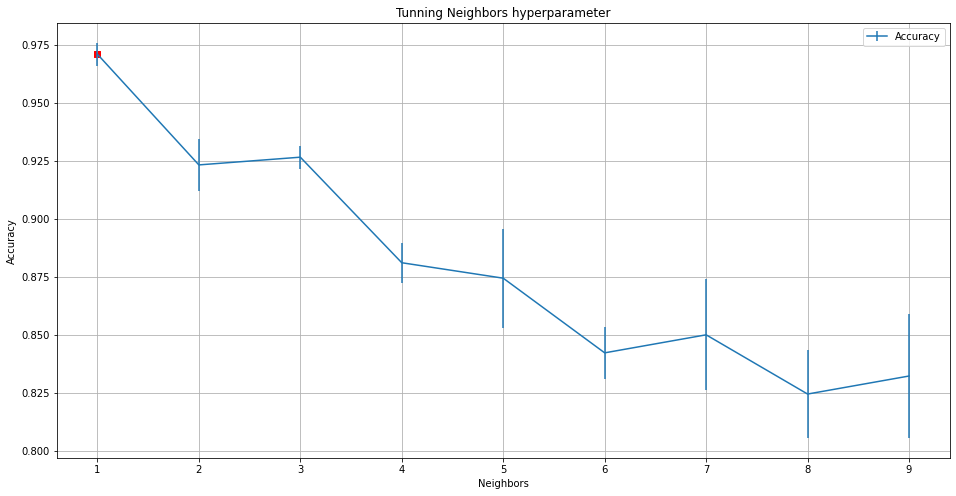

In [16]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('Tunning Neighbors hyperparameter')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.errorbar(neighbors, np.mean(accs, axis=1), np.std(accs, axis=1), label='Accuracy')
plt.xticks(neighbors)
plt.grid()

criterion_acc = np.mean(accs, axis=1)
idx_opt = np.argmax(criterion_acc)
neighbor_optimal = neighbors[idx_opt]

plt.scatter(neighbor_optimal, np.mean(accs, axis=1)[idx_opt], color='red', marker='s')

plt.legend()
plt.show()

<div dir="rtl">
حال با استفاده از neighbor بهینه اقدام به ساخت طبقه بند با تمام داده های آموزشی و ارزیابی آن با مجموعه validation می کنیم
</div>

In [17]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=neighbor_optimal)
knn.fit(X, y)

y_pred = knn.predict(X_val)

              precision    recall  f1-score   support

          HC     0.9091    0.7895    0.8451        38
          PD     0.9328    0.9737    0.9528       114

    accuracy                         0.9276       152
   macro avg     0.9209    0.8816    0.8989       152
weighted avg     0.9269    0.9276    0.9259       152



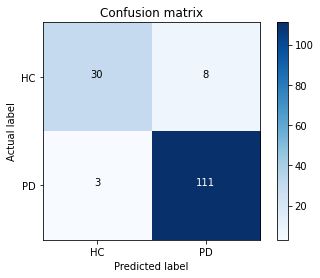

In [18]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

knn_report = classification_report(y_val, y_pred, target_names=['HC', 'PD'],
                                   digits=4, output_dict=True)
print(classification_report(y_val, y_pred, target_names=['HC', 'PD'], digits=4))

cm = confusion_matrix(y_val, y_pred)  
plot_confusion_matrix(cm, ['HC', 'PD'])

# Classification with Dimensionality Reduction

<div dir="rtl">
با توجه به اینکه تعداد ابعاد بردار ویژگی بسیار زیاد می باشد و با مشکل curse of dimensionality رو به رو هستیم نیاز به استفاده از روش های dimensionality reduction به منظور رسیدن به مدل robust تر هستیم.
<br />
روش نهایی انتخاب شده برای کاهش بعد ترکیبی از دو روش autoencoder و pca می باشد. به این صورت که ابتدا با استفاده از روش autoencoder تعداد ابعاد بردار ویژگی را به ۱۸۸ کاهش می دهیم (تقسیم بر ۴ میکنیم) و در نهایت از بین این ۱۸۸ ویژگی با استفاده از روش pca ۲۰ ویژگی را انتخاب می کنیم
</div>

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=85)

# number of input columns
n_inputs = X_train.shape[1]

# define encoder
visible = Input(shape=(n_inputs,))
# encoder level 1
e = Dense(n_inputs)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)
# bottleneck
n_bottleneck = round(float(n_inputs) / 4.0)
bottleneck = Dense(n_bottleneck)(e)
# define decoder, level 1
d = Dense(n_inputs)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)
# output layer
output = Dense(n_inputs, activation='linear')(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)
# compile autoencoder model
model.compile(optimizer='adam', loss='mse')

# plot the autoencoder
plot_model(model, 'autoencoder_compress.png', show_shapes=True)

# fit the autoencoder model to reconstruct input
history = model.fit(X_train, X_train, epochs=100, batch_size=16,
                    validation_data=(X_test, X_test))

Epoch 1/100
43/43 [==============================] - 2s 24ms/step - loss: 0.2518 - val_loss: 0.0382
Epoch 2/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0265 - val_loss: 0.0523
Epoch 3/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0201 - val_loss: 0.0371
Epoch 4/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0198 - val_loss: 0.0201
Epoch 5/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0159 - val_loss: 0.0257
Epoch 6/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0177 - val_loss: 0.0143
Epoch 7/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0134 - val_loss: 0.0206
Epoch 8/100
43/43 [==============================] - 1s 15ms/step - loss: 0.0173 - val_loss: 0.0129
Epoch 9/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0122 - val_loss: 0.0151
Epoch 10/100
43/43 [==============================] - 1s 16ms/step - loss: 0.0129 - val_loss: 0.0223

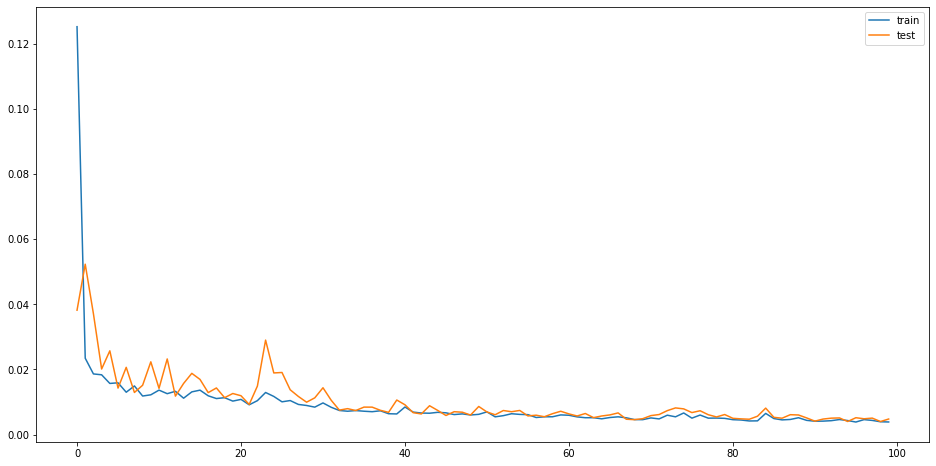

In [20]:
# plot loss for checking convergence
plt.figure(figsize=(16, 8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [21]:
# define an encoder model (without the decoder)
encoder = Model(inputs=visible, outputs=bottleneck)

# save the encoder to file
encoder.save('encoder.h5')

In [22]:
from tensorflow.keras.models import load_model

# load the model from file
encoder = load_model('encoder.h5')

X_encode = encoder.predict(X)
X_val_encode = encoder.predict(X_val)
X_encode.shape, X_val_encode.shape

((900, 188), (152, 188))

In [23]:
from sklearn.decomposition import PCA

pca = PCA(whiten=True, n_components=20)
pca.fit(X_encode)

X_encode_trans = pca.transform(X_encode)
X_val_encode_trans = pca.transform(X_val_encode)
X_encode_trans.shape, X_val_encode_trans.shape

((900, 20), (152, 20))

## Generative

### Parzen

<div dir="rtl">
در این قسمت با استفاده از روش تخمین ناپارامتری Parzen Window اقدام به ساختن یک طبقه بند Bayes Optimal Classifier می کنیم. با توجه به اینکه تعداد داده ها دو کلاس PD و HC در مجموعه training برابر می باشد احتمال پیشین مربوط به دو کلاس را برابر در نظر می گیریم.
<br />
برای ساخت طبقه بند تخمین Parzen را با پنجره ی gaussian در نظر می گیریم و برای بدست آوردن bandwidth بهینه از روش k-fold (k=4) بعنوان cross validation استفاده می کنیم.
</div>

In [24]:
import numpy as np

from sklearn.model_selection import KFold
from sklearn.neighbors import KernelDensity
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

bws = np.linspace(0.1, 1, 10)
accs = []
f1s = []
for bw in bws:
  kf = KFold(n_splits=4, shuffle=True, random_state=85)

  accs_cv = []
  f1s_cv = []
  for train_index, test_index in kf.split(X_encode_trans):
    X_train, X_test = X_encode_trans[train_index], X_encode_trans[test_index]
    y_train, y_test = y[train_index], y[test_index]

    kde0 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(X_train[y_train==0])
    kde1 = KernelDensity(kernel='gaussian', bandwidth=bw).fit(X_train[y_train==1])

    prob0 = kde0.score_samples(X_test)
    prob1 = kde1.score_samples(X_test)
    y_pred = (prob1 >= prob0).astype('int8')
    accs_cv.append(accuracy_score(y_test, y_pred))
    f1s_cv.append(f1_score(y_test, y_pred))

  accs.append(accs_cv)
  f1s.append(f1s_cv)

<div dir="rtl">
با توجه به اینکه تعداد داده های دو کلاس متعادل هستند تنها از معیار accuracy برای انتخاب مقدار بهینه bandwidth استفاده می کنیم. همانطور که در شکل زیر مشاهده می شود مقدار بهینه bandwidth برابر 0.6 می باشد. (این مقدار بیشترین accuracy را بدون توجه به پراکندگی دارد) 
</div>

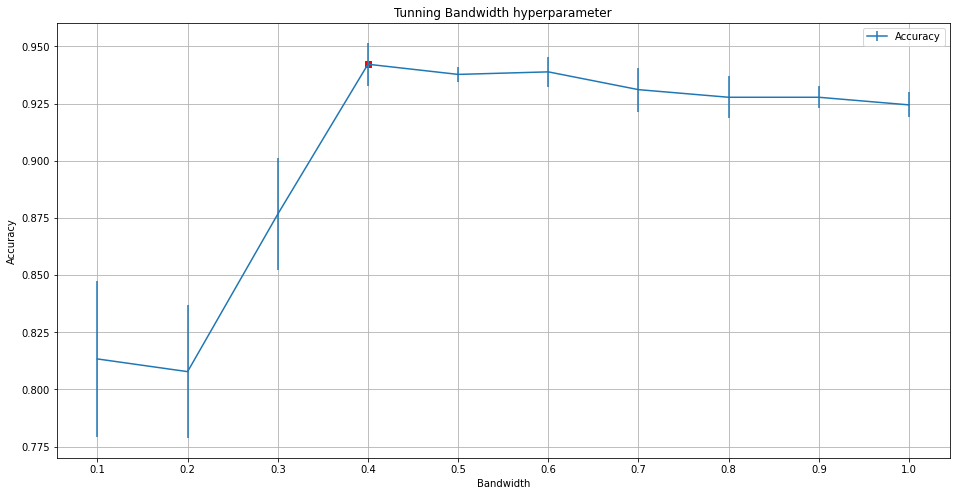

In [25]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('Tunning Bandwidth hyperparameter')
plt.xlabel('Bandwidth')
plt.ylabel('Accuracy')
plt.errorbar(bws, np.mean(accs, axis=1), np.std(accs, axis=1), label='Accuracy')
plt.xticks(bws)
plt.grid()

criterion_acc = np.mean(accs, axis=1)
idx_opt = np.argmax(criterion_acc)
bw_optimal = bws[idx_opt]

plt.scatter(bw_optimal, np.mean(accs, axis=1)[idx_opt], color='red', marker='s')

plt.legend()
plt.show()

<div dir="rtl">
حال با استفاده از bandwidth بهینه اقدام به ساخت طبقه بند با تمام داده های آموزشی و ارزیابی آن با مجموعه validation می کنیم
</div>

In [26]:
from sklearn.neighbors import KernelDensity

kde0 = KernelDensity(kernel='gaussian', bandwidth=0.6).fit(X_encode_trans[y==0])
kde1 = KernelDensity(kernel='gaussian', bandwidth=0.6).fit(X_encode_trans[y==1])

prob0 = kde0.score_samples(X_val_encode_trans)
prob1 = kde1.score_samples(X_val_encode_trans)

y_pred = (prob1 >= prob0).astype('int8')

              precision    recall  f1-score   support

          HC     0.6977    0.7895    0.7407        38
          PD     0.9266    0.8860    0.9058       114

    accuracy                         0.8618       152
   macro avg     0.8121    0.8377    0.8233       152
weighted avg     0.8694    0.8618    0.8646       152



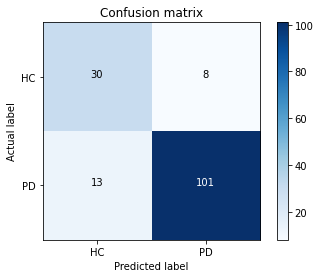

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

dr_parzen_report = classification_report(y_val, y_pred, target_names=['HC', 'PD'],
                                         digits=4, output_dict=True)
print(classification_report(y_val, y_pred, target_names=['HC', 'PD'], digits=4))

cm = confusion_matrix(y_val, y_pred)  
plot_confusion_matrix(cm, ['HC', 'PD'])

## Discriminative

### KNN Classifier

<div dir="rtl">
در این قسمت اقدام به ساخت طبقه بند KNN می کنیم و برای بدست آوردن تعداد بهینه neighbor از روش k-fold(k=4) بعنوان cross validation استفاده می کنیم
</div>

In [28]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

neighbors = range(1, 10)
accs = []
f1s = []
for k in neighbors:
  knn = KNeighborsClassifier(n_neighbors=k)
  cv = KFold(n_splits=4, shuffle=True, random_state=85)
  cv_results = cross_validate(knn, X_encode_trans, y, cv=cv, scoring=('accuracy', 'f1'))

  accs.append(cv_results['test_accuracy'])
  f1s.append(cv_results['test_f1'])

<div dir="rtl">
با توجه به اینکه تعداد داده های دو کلاس متعادل هستند تنها از معیار accuracy برای انتخاب مقدار بهینه neighbor استفاده می کنیم. همانطور که در شکل زیر مشاهده می شود مقدار بهینه neighbor برابر 1 می باشد. (این مقدار بیشترین accuracy را بدون توجه به پراکندگی دارد) 
</div>

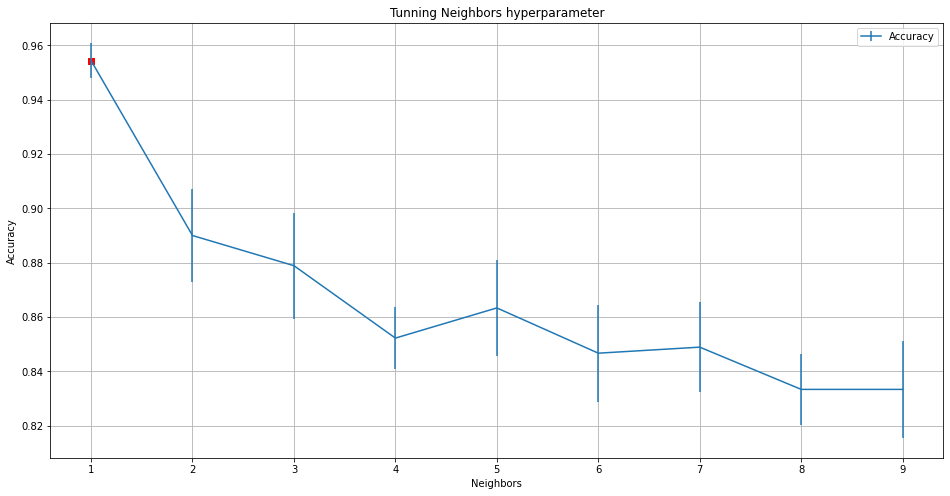

In [29]:
import numpy as np

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.title('Tunning Neighbors hyperparameter')
plt.xlabel('Neighbors')
plt.ylabel('Accuracy')
plt.errorbar(neighbors, np.mean(accs, axis=1), np.std(accs, axis=1), label='Accuracy')
plt.xticks(neighbors)
plt.grid()

criterion_acc = np.mean(accs, axis=1)
idx_opt = np.argmax(criterion_acc)
neighbor_optimal = neighbors[idx_opt]

plt.scatter(neighbor_optimal, np.mean(accs, axis=1)[idx_opt], color='red', marker='s')

plt.legend()
plt.show()

<div dir="rtl">
حال با استفاده از neighbor بهینه اقدام به ساخت طبقه بند با تمام داده های آموزشی و ارزیابی آن با مجموعه validation می کنیم
</div>

In [30]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=neighbor_optimal)
knn.fit(X_encode_trans, y)

y_pred = knn.predict(X_val_encode_trans)

              precision    recall  f1-score   support

          HC     0.7368    0.7368    0.7368        38
          PD     0.9123    0.9123    0.9123       114

    accuracy                         0.8684       152
   macro avg     0.8246    0.8246    0.8246       152
weighted avg     0.8684    0.8684    0.8684       152



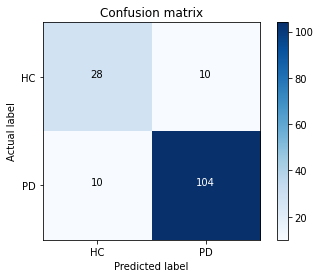

In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

dr_knn_report = classification_report(y_val, y_pred, target_names=['HC', 'PD'],
                                      digits=4, output_dict=True)
print(classification_report(y_val, y_pred, target_names=['HC', 'PD'], digits=4))

cm = confusion_matrix(y_val, y_pred)  
plot_confusion_matrix(cm, ['HC', 'PD'])

# Compare Models

<div dir="rtl">
همان طور که در جدول زیر مشاهده می شود بهترین نتایج بدست آمده متعلق به حالتی است که Dimensionality Reduction نداشته و از طبقه بند Parzen استفاده می کنیم.
</div>

In [32]:
import pandas as pd

idx = pd.MultiIndex.from_product([['No DR', 'DR'],
                                 ['Parzen', 'SVM', 'KNN Classifier']])

col = ['Accuracy', 'F1 Score']

report_df = pd.DataFrame('-', idx, col)
report_df.loc[('No DR', 'Parzen')] = parzen_report['accuracy'], parzen_report['PD']['f1-score']
report_df.loc[('No DR', 'SVM')] = svm_report['accuracy'], svm_report['PD']['f1-score']
report_df.loc[('No DR', 'KNN Classifier')] = knn_report['accuracy'], knn_report['PD']['f1-score']

report_df.loc[('DR', 'Parzen')] = dr_parzen_report['accuracy'], dr_parzen_report['PD']['f1-score']
report_df.loc[('DR', 'KNN Classifier')] = dr_knn_report['accuracy'], dr_knn_report['PD']['f1-score']

display(report_df)

Accuracy  F1 Score
No DR Parzen          0.940789  0.960699
      SVM             0.927632  0.953191
      KNN Classifier  0.927632   0.95279
DR    Parzen          0.861842   0.90583
      SVM                    -         -
      KNN Classifier  0.868421  0.912281